### Goal
Model to predict from blood to Muscle - Skeletal.
In total 220 training samples.

### TODO
- basic linear regression (with bias)
- add PCA = 50
- add Embeddings
- add weight decay

In [25]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from fastai.basics import *
import torch
import rep.preprocessing_new as p
import rep.datasets as d

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(999)

In [26]:
manualSeed = 1

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# if you are suing GPU
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)


torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
os.getcwd()

'/home/mada/Uni/Masterthesis/online_repo/rep/notebooks/random'

In [4]:
inputs = p.RepAnnData.read_h5ad(os.path.join("..", "..","data","processed","gtex","input_data","X_inputs_pc_onlyblood.h5"))
targets = p.RepAnnData.read_h5ad(os.path.join("..", "..","data","processed","gtex","input_data","Y_targets_pc_onlyblood.h5"))
x_train_all = inputs[inputs.samples['Type']=='train']
x_valid_all = inputs[inputs.samples['Type']=='valid']
y_train_all = targets[targets.samples['Type']=='train']
y_valid_all = targets[targets.samples['Type']=='valid']  

#### Number of (Blood - Tissue pairs) in the training set

In [5]:
inputs.samples[inputs.samples['Type'] == 'train'][['From_tissue','To_tissue']].groupby('To_tissue').count().sort_values('From_tissue',ascending=False)[:10]

,From_tissue
To_tissue,
Muscle - Skeletal,220
Skin - Sun Exposed (Lower leg),193
Adipose - Subcutaneous,189
Lung,183
Artery - Tibial,181
Cells - Transformed fibroblasts,179
Nerve - Tibial,164
Thyroid,162
Esophagus - Mucosa,154


In [6]:
del inputs, targets

#### Use as input data the Blood -> Muscle - Skeletal as training samples

In [7]:
x_train = np.array(x_train_all[x_train_all.obs['To_tissue'] == 'Muscle - Skeletal'].X)[:,:100]
del x_train_all
y_train = np.array(y_train_all[y_train_all.obs['To_tissue'] == 'Muscle - Skeletal'].X)[:,:100]
del y_train_all
x_valid = np.array(x_valid_all[x_valid_all.obs['To_tissue'] == 'Muscle - Skeletal'].X)[:,:100]
del x_valid_all
y_valid = np.array(y_valid_all[y_valid_all.obs['To_tissue'] == 'Muscle - Skeletal'].X)[:,:100]
del y_valid_all

In [8]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([220, 100]), tensor(-5.7935), tensor(2.6615))

In [9]:
bs=2
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [10]:
del x_train,x_valid,y_train,y_valid

In [11]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([2, 100]), torch.Size([2, 100]))

In [69]:
class Blood2TissueRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(2,100,1)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(50,64,5)),
          ('relu2', nn.ReLU()),
          ('lin1',nn.Linear(64, 100, bias=True))

        ]))
#         self.lin1 = nn.Linear(100, 50, bias=True)
#         self.lin2 = nn.Linear(50, 20, bias=True)
#         self.lin3 = nn.Linear(20, 100, bias=True)


    def forward(self, xb): 
        x = self.model(xb)
#         x = F.relu(x)
#         y = self.lin2(x)
#         y = F.relu(y)
        return x

In [71]:
model = Blood2TissueRegression().cuda()

In [73]:
lr=0.001
loss_func = nn.MSELoss()

In [64]:
[p.shape for p in model.parameters()]

[torch.Size([100, 2, 5, 5]),
 torch.Size([100]),
 torch.Size([64, 50, 5, 5]),
 torch.Size([64]),
 torch.Size([100, 64]),
 torch.Size([100])]

In [74]:
def update(x,y,lr):
    wd = 1e-3
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): 
        w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [75]:
for epoch in range(10):  # loop over the dataset multiple times
    losses = [update(x,y,0.001) for x,y in data.train_dl]

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [100, 2, 1, 1], but got 2-dimensional input of size [2, 100] instead

In [34]:
len(losses)

110

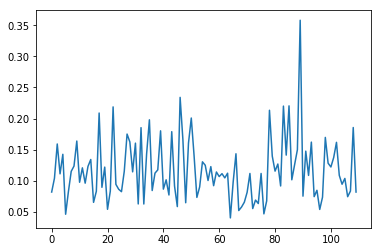

In [35]:
plt.plot(losses);

In [36]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

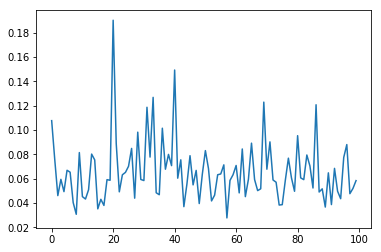

In [42]:
loss_epoch = []
for epoch in range(100):
    losses = [update(x,y,1e-04) for x,y in data.train_dl]
    loss_epoch.append(losses[-1])
plt.plot(loss_epoch);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


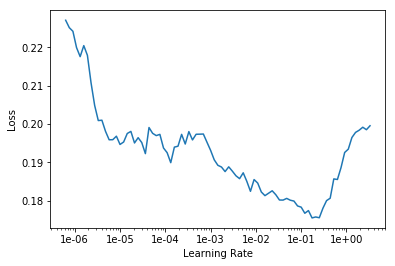

In [32]:
learn = Learner(data, Blood2TissueRegression(), loss_func=loss_func, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()